In [25]:
from torch import nn
import pandas as pd
import sqlite3
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import math
import numpy as np
from climb_conversion import ClimbsFeatureArray
from simple_diffusion import ResidualBlock1D, Denoiser
import numpy as np
import pandas as pd
import sqlite3
import json
import math
import torch
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch_geometric.data import Data, InMemoryDataset
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary
import seaborn as sns

In [48]:
class Noiser(nn.Module):
    def __init__(self, hidden_dim=128, layers = 5):
        super().__init__()

        self.cond_mlp = nn.Sequential(
            nn.Linear(5, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.init_conv = ResidualBlock1D(4, hidden_dim, hidden_dim)

        self.residuals = nn.ModuleList([ResidualBlock1D(hidden_dim, hidden_dim, hidden_dim) for _ in range(layers)])

        self.head = nn.Conv1d(hidden_dim, 4, 1)
    
    def forward(self, climbs: Tensor, cond: Tensor, t: Tensor)-> Tensor:
        """
        Run denoising pass. Predicts the added noise from the noisy data.
        
        :param climbs: Tensor with hold-set positions. [B, S, 4]
        :param cond: Tensor with conditional variables. [B, 4]
        :param t: Tensor with timestep of diffusion. [B, 1]
        """
        emb_c = self.cond_mlp(torch.cat([cond,t], dim=1))
        emb_h = self.init_conv(climbs.transpose(1,2), emb_c)

        for layer in self.residuals:
            layer(emb_h, emb_c)

        result = self.head(emb_h).transpose(1,2)

        return result
class ClimbDDPM(nn.Module):
    def __init__(self, model, predict_noise = False):
        super().__init__()
        self.model = model
        self.timesteps = 100
        self.pred_noise = predict_noise
    
    def loss(self, sample_climbs, cond):
        """Perform a diffusion Training step and return the loss resulting from the model in the training run. Currently returns tuple (loss, real_hold_loss, null_hold_loss)"""
        B = sample_climbs.shape[0]
        S = sample_climbs.shape[1]
        H = sample_climbs.shape[2]
        C = cond.shape[1]
        t = torch.round(torch.rand(B,1), decimals=2)

        noisy = self._forward_diffusion(sample_climbs, t)

        pred_clean = self.predict(noisy, cond, t)
        is_real = (sample_climbs[:,:,3] != -2).float().unsqueeze(-1)
        is_null = (sample_climbs[:,:,3] == -2).float().unsqueeze(-1)
        real_hold_loss = self._real_hold_loss(pred_clean, sample_climbs, is_real)
        null_hold_loss = self._null_hold_loss(pred_clean, is_null)
        return real_hold_loss + null_hold_loss, real_hold_loss, null_hold_loss
    
    def predict(self, noisy, cond, t):
        """Return predicted clean data (noisy-pred_noise if the model predicts noise)"""
        prediction = self.model(noisy, cond, t)
        clean = noisy - prediction if self.pred_noise else prediction
        return clean
    
    def _null_hold_loss(self, pred_clean, null_mask):
        """Calculate loss over the null holds"""
        return F.mse_loss(torch.square(pred_clean)*null_mask, null_mask*4)*2
    
    def _real_hold_loss(self, pred_clean, sample_climbs, real_mask):
        """Get loss over the real holds"""
        return F.mse_loss(pred_clean*real_mask, sample_climbs*real_mask)
    
    def _forward_diffusion(self, clean: Tensor, t: Tensor)-> Tensor:
        """Perform forward diffusion to add noise to clean data based on noise adding schedule."""
        a = self._cos_alpha_bar(t)
        return torch.sqrt(a) * clean + torch.sqrt(1-a) * torch.randn_like(clean)
    
    def _cos_alpha_bar(self, t: Tensor)-> Tensor:
        t = t.view(-1,1,1)
        epsilon = 0.0001
        return  torch.cos((t+epsilon)/(1+epsilon)*torch.pi/2)**2
    
    def generate(
        self,
        n: int,
        angle: int,
        grade: int | None = None,
        show_steps: bool = False
    ):
        """
        Generate a climb or batch of climbs with the given conditions using the standard DDPM iterative denoising process.
        
        :param n: Number of climbs to generate
        :type n: int
        :param angle: Angle of the wall
        :type angle: int
        :param grade: Desired difficulty (V-grade)
        :type grade: int | None
        :return: A Tensor containing the denoised generated climbs as hold sets.
        :rtype: Tensor
        """
        cond = Tensor([[grade/9-0.5 if grade else 0.0, angle/90.0, 1.0, 1.0] for _ in range(n)])

        gen_climbs = torch.randn((n, 20, 4))
        t_tensor = torch.ones((n,1))

        for t in range(1, self.timesteps):
            gen_climbs = self.predict(gen_climbs, cond, t_tensor)
            print('.',end='')
            if t == self.timesteps-1:
                break

            t_tensor -= .01
            gen_climbs = self._forward_diffusion(gen_climbs, t_tensor)
        
        return gen_climbs

class DDPMTrainer():
    def __init__(
        self,
        model: nn.Module,
        dataset: TensorDataset | None = None,
        default_batch_size: int = 64
    ):
        self.model = model
        self.dataset = dataset
        self.default_batch_size = default_batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    def train(
        self,
        epochs: int,
        save_path: str,
        batch_size: int | None = None,
        dataset: TensorDataset | None = None,
        save_on_best: bool = False,
    )-> tuple[nn.Module, list]:
        """
        Train a model (probably of type ClimbDDPM) on the dataset contained in the trainer. (If dataset is provided, train on that dataset instead)

        :param epochs: Number of training epochs
        :type epochs: int
        :param save_path: Model weights save-path
        :type save_path: str
        :param batch_size: Training batch size
        :type batch_size: int | None
        :param dataset: Training Dataset; defaults to model.dataset
        :type dataset: TensorDataset | None
        :param save_on_best: boolean indicating whether to save model weights every time a minimum loss is reached.
        :type save_on_best: bool
        :return: Tuple of (best_model: nn.Module, training_data: np.array)
        :rtype: tuple[Module, Any]
        """
        if dataset is None:
            dataset = self.dataset
        if dataset is None:
            raise ValueError("Dataset is None. Cannot train on no dataset")
        if batch_size is None:
            batch_size = self.default_batch_size

        batches = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        losses = []

        with tqdm(range(epochs)) as pbar:
            for epoch in pbar:
                total_loss = [0, 0, 0]
                for x, c in batches:
                    self.optimizer.zero_grad()
                    loss, real_hold_loss, null_hold_loss = self.model.loss(x, c)
                    loss.backward()
                    self.optimizer.step()

                    # Calc total losses
                    total_loss[0] += loss.item()
                    total_loss[1] += real_hold_loss.item()
                    total_loss[2] += null_hold_loss.item()
                
                improvement = total_loss[0] - losses[-1][0] if len(losses) > 0 else 0
                pbar.set_postfix_str(f"Epoch: {epoch}, Batches:{len(batches)} Total Loss: {total_loss[0]:.2f}, Real Hold Loss: {total_loss[1]:.2f}, Null Hold Loss: {total_loss[2]:.2f}, Improvement: {improvement:.2f}")
                losses.append(total_loss)

                if save_on_best and total_loss > min(losses) and len(losses) % 2 == 0:
                    torch.save(self.model.state_dict(), save_path)
        torch.save(self.model.state_dict(), save_path)
        return self.model, losses

class ClimbsFeatureArray:
    def __init__(
            self,
            db_path: str = "data/storage.db",
            to_length: int = 20
        ):
        """Gets climbs from the climbs database and converts them into featured Sequence data for our DDPM."""
        self.scaler = MinMaxScaler(feature_range=(-1,1))
        with sqlite3.connect(db_path) as conn:
                # Load Climbs
                fdf = pd.read_sql_query(
                    f"SELECT * FROM climbs WHERE ascents > 1", 
                    conn, index_col="id"
                )
                fdf['holds'] = fdf['holds'].apply(json.loads)
                fdf = fdf[fdf['holds'].str.len() <= to_length].copy()
                fdf['angle'] = fdf['angle'].astype(int)

                # Normalize these columns to (-1,1) for feature conditioning.
                fdf['grade'] = self.scaler.fit_transform(fdf[['grade']])
                fdf['quality'] = self.scaler.fit_transform(fdf[['quality']])
                fdf['ascents'] = self.scaler.fit_transform(fdf[['ascents']])
                self.climbs_df = fdf
                
                # Initialize walls:
                walls = [_tuple[0] for _tuple in conn.execute("SELECT id FROM walls").fetchall()]
                self.holds = {}

                # Load Holds
                for wall_id in walls:
                    hdf = pd.read_sql_query(
                    "SELECT hold_index, x, y, pull_x, pull_y, useability, is_foot FROM holds WHERE wall_id LIKE ?", 
                    conn, params=(wall_id,), index_col='hold_index'
                    )
                    # Apply usability factor
                    mult = hdf['useability']/((3*hdf['is_foot'])+1)
                    hdf['pull_y'] *= mult
                    hdf['pull_x'] *= mult
                    # Scale climbs to unit scale They will eventually be in range (-1,1), so divide by 1/2 wall size (12x12).
                    hdf['x'] /= 6
                    hdf['y'] /= 6
                    hdf.drop(columns=['useability','is_foot'], inplace=True)
                    self.holds[wall_id] = hdf
        self.to_length = to_length
        self.db_path = db_path

    def apply_wall_angle(self, angle, val):
        rads = math.radians(angle)
        return val * math.cos(rads), val * math.sin(rads)

    def _zero_center_of_mass(self, f_arr, dim=2):
        """Return the center-of-mass of the climbing hold positions"""
        com = np.mean(f_arr[:,:dim], axis=0)
        f_arr[:,:dim] -= com
        
        return f_arr
    
    def get_features_3d(self, continuous_only = False):
        """Converts a list of hold indices + roles to a 3d-point cloud and pads the sequence by adding NULL holds."""
        x_features = []
        cond_features = []
        for _, row in self.climbs_df.iterrows():
            try:
                x, cond = self.embed_features_3d(row, self.to_length, continuous_only)
                x_features.append(x)
                cond_features.append(cond)
            except:
                continue
        return Tensor(np.array(x_features)), Tensor(np.array(cond_features))
    
    def get_features_2d(self, continuous_only = False, augment_reflections = True):
        """Converts a list of hold indices + roles to a 3d-point cloud and pads the sequence by adding NULL holds."""
        x_features = []
        cond_features = []
        for _, row in self.climbs_df.iterrows():
            try:
                x, cond = self.embed_features_2d(row, self.to_length, continuous_only)
                x_features.append(x)
                cond_features.append(cond)
            except:
                continue

        if augment_reflections:
            refl = np.array([-1,1,-1,1]) * x_features
            x_features = np.concatenate([x_features, refl], axis=0)
            cond_features = np.tile(cond_features,(2,1))
        return Tensor(np.array(x_features)), Tensor(np.array(cond_features))

    def embed_features_2d(self, row, to_length, continuous_only):
        """Converts a list of hold indices + roles to a 2d-point cloud and pads the sequence by adding random NULL holds. Currently sorts by y, then x value."""
        pad_length = to_length-len(row["holds"])
        assert pad_length >= 0

        _2d_features = []
        one_hot_encoder = np.eye(5)

        for hold in row["holds"]:
            features = [f for f in self.holds[row['wall_id']].loc[hold[0]]]

            if not continuous_only:
                features.extend([ohr for ohr in list(one_hot_encoder[hold[1]])])
            _2d_features.append(features)

        features_arr = np.array(_2d_features, dtype=np.float32)
        features_arr = self._zero_center_of_mass(features_arr)
        features_arr = np.array(sorted(features_arr, key=(lambda arr: arr[0]+10*arr[1])))
        if pad_length > 0:
            null_holds = np.tile(np.array([0,-2,0,-2]),(pad_length,1))
            features_arr = np.concatenate([features_arr,null_holds], axis=0, dtype=np.float32)
        
        # Add conditioning features (Grade, Rating, Ascents)
        conditional_features = np.array([row['grade'],row['angle']/90, row['quality'],row['ascents']], dtype=np.float32)
        return (features_arr, conditional_features)
    
    def embed_features_3d(self, row, to_length, continuous_only, augment_reflections = True):
        """Embed a single row of the climbs dataframe into 3d features."""
        pad_length = to_length-len(row["holds"])
        assert pad_length >= 0

        _3d_features = []
        eye_encoder = np.eye(5)
        # Initial embeddings.
        for hold in row["holds"]:
            role_encoding = list(eye_encoder[hold[1]])
            features = self.holds[row['wall_id']].loc[hold[0]]
            x, y, pull_x, pull_y, is_foot = [f for f in features]
            y, z = self.apply_wall_angle(row["angle"], y)
            pull_y, pull_z = self.apply_wall_angle(row["angle"], pull_y)
            features=[x, y, z, pull_x, pull_y, pull_z, is_foot]
            if not continuous_only:
                features.extend([ohr for ohr in role_encoding])
            _3d_features.append(features)
        features_arr = np.array(_3d_features, dtype=np.float32)
        # Zero-centering climb around the starting holds.
        features_arr = self._zero_center_of_mass(features_arr,dim=3)
        # Re-order holds based on distance from starting holds.
        features_arr = np.array(sorted(features_arr, key=(lambda arr: np.sqrt(arr[0]**2+arr[1]**2+arr[2]**2))))
        # Pad with NULL holds:
        null_holds = np.concatenate([np.full((pad_length,features_arr.shape[1]-1),0),np.ones((pad_length,1))], axis=1)
        hold_features = np.concatenate([features_arr,null_holds], axis=0, dtype=np.float32)
        
        # Add conditioning features (Grade, Rating, Ascents)
        conditional_features = np.array([row['grade'], row['quality'],row['ascents'],row['angle']/90], dtype=np.float32)
        return (hold_features, conditional_features)
# climbs = ClimbsFeatureArray(db_path='../data/storage.db')
# dataset = climbs.get_features_2d(continuous_only=True)

In [49]:
model = ClimbDDPM(model=Noiser(), predict_noise=True)
model.load_state_dict(torch.load("simple_diffusion2.pt", map_location='cpu'))
trainer = DDPMTrainer(
    model = model,
    dataset = TensorDataset(*dataset)
)

C:\Users\EvanM\AppData\Local\Temp\ipykernel_8872\2222630552.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("simple_diffusion2.pt", map_

In [ ]:
model, loss = trainer.train(epochs=100, save_path="simple_diffusion2.pt", save_on_best=True, batch_size=256)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\EvanM\AppData\Local\Temp\ipykernel_8872\3092815693.py:66: UserWarning: Using a target size (torch.Size([256, 20, 1])) that is different to the input size (torch.Size([256, 20, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(torch.square(pred_clean)*null_mask, null_mask*4)*2


...................................................................................................[[ 0.62  0.62 -0.66  0.01]
 [-1.96 -1.94  1.92 -1.94]
 [-1.98 -1.98  1.96 -1.97]
 [-1.97 -1.98  1.96 -1.98]
 [-1.98 -1.98  1.96 -1.98]
 [-1.98 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.98 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.97 -1.98  1.96 -1.98]
 [-1.98 -1.98  1.96 -1.98]
 [-1.98 -1.98  1.96 -1.98]
 [-1.98 -1.98  1.95 -1.98]
 [-1.99 -1.99  1.97 -1.98]]


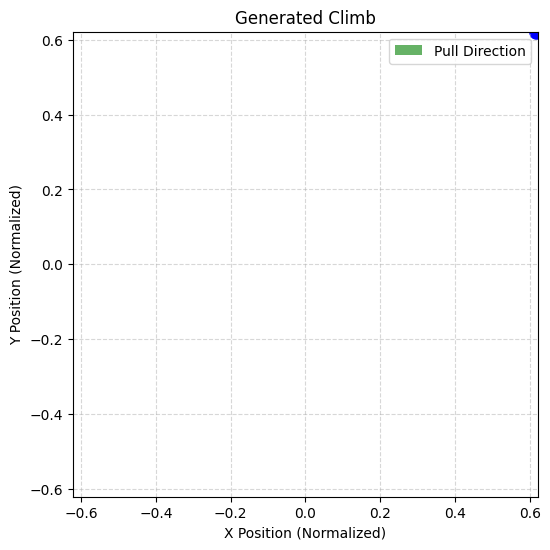

In [45]:
def plot_climb(climb_data, title="Generated Climb"):
    """
    Visualizes a climb generated by a neural network.
    
    Args:
        climb_data (np.array): Shape [N, 5]. 
                               Features: [x, y, pull_x, pull_y, is_foot]
        title (str): Title for the plot.
    """
    real_holds = climb_data[np.abs(climb_data[:,0]) < 1.1]
    x, y, pull_x, pull_y = real_holds[:13].T

    # 2. Setup the Plot
    # Climbing walls are vertical, so we use a tall figsize
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # 3. Plot Hand Holds (Circles, Blue)
    # We filter using the inverted boolean mask
    ax.scatter(x, y, c='blue', s=90)

    # 5. Plot Pull Vectors (Arrows)
    # quiver(x, y, u, v) plots arrows at (x,y) with direction (u,v)
    ax.quiver(x, y, pull_x, pull_y, 
              color='green', alpha=0.6, 
              angles='xy', scale_units='xy', scale=1, 
              width=0.005, headwidth=4,
              label='Pull Direction', zorder=1)

    # 6. Formatting
    ax.set_title(title)
    ax.set_xlabel("X Position (Normalized)")
    ax.set_ylabel("Y Position (Normalized)")
    
    # Important: set aspect to 'equal' so the wall doesn't look stretched
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')

    # Optional: Center the view if the data is normalized around 0
    # You can remove these lines if you want auto-scaling
    max_range = np.max(np.abs(real_holds[:, :2]))
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    plt.show()

climb = model.generate(1,45).detach().numpy().reshape(-1,4)
print(np.round(climb,2))
plot_climb(climb)

True